In [3]:
import numpy as np
import ee
import geopandas as gpd
import sys
sys.path.append('../python')
import lem
import rasterio as rio
import os
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
octo_points = gpd.read_file('../example_data/octo_all_points')
octo_basins = gpd.read_file('../example_data/nz_basins_')
octo_basins_orig = octo_basins.copy()
octo_points.index = octo_points.OBSID1
octo_basins.index = octo_basins.OBSID1

octo_points = octo_points.loc[octo_basins.index] #Because we can only download all the points at once...
#octo_points = octo_points.to_crs('EPSG:4326')
octo_basins = octo_basins.to_crs('EPSG:4326')
octo_basins.geometry = octo_basins.geometry.buffer(.05)
octo_points.index = range(len(octo_points))
octo_basins.index = range(len(octo_basins))

/var/folders/5v/804c95h92bx2zr8rfpwyr_yc0000gn/T/ipykernel_1079/2568616956.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  octo_basins.geometry = octo_basins.geometry.buffer(.05)
/Users/gr_1/miniconda3/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


<Axes: >

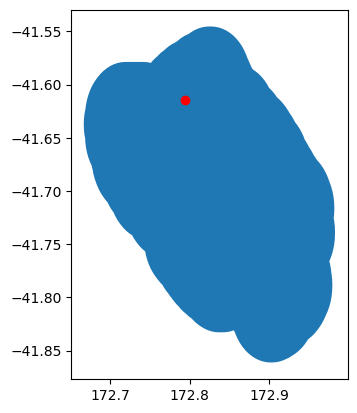

In [3]:
fix,ax = plt.subplots(1,1)
octo_basins.loc[8:8.5].plot(ax=ax)
octo_points.loc[8:8.5].plot(ax=ax,color='r')

<Axes: >

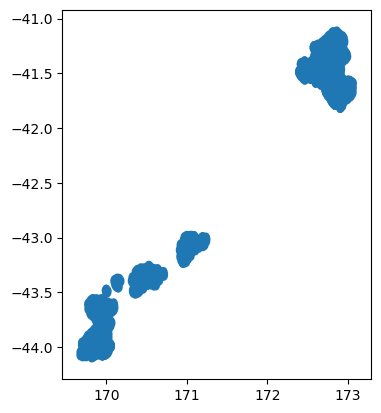

In [4]:
fig,ax = plt.subplots(1,1)
octo_basins.plot(ax=ax)
octo_points.plot(ax=ax)

In [5]:
F = lem.simple_model()

In [15]:
from numba.experimental import jitclass
class testinher(lem.simple_model):
    def __init__():
        print(f.Z)

TypeError: cannot subclass from a jitclass

## Download Octopus data from octopusdata.org
## You can clip the tiles for DEMs using EarthEngine

In [16]:
import json 
from ee.geometry import Geometry
basin_slopes = gpd.GeoDataFrame()
basin_slopes_t = gpd.GeoDataFrame()

shps = []
image = ee.Image("WWF/HydroSHEDS/03VFDEM").setDefaultProjection('EPSG:4326',None,30)
for i,row in octo_basins.iterrows(): 
    #if i in unique:# remove unique line for full basins
        if row.geometry.type=='MultiPolygon':
                asi = [geom.area for geom in row.geometry.geoms]
                xy2 = row.geometry.geoms[np.argmax(asi)].exterior.xy
                sh = list(zip(xy2[0],xy2[1]))
                shp = Geometry.Polygon(sh)
                print(i)
        else:
            try:
                sh = list(zip(row.geometry[-1].exterior.coords.xy[0],row.geometry[-1].exterior.coords.xy[1]))
            except:
                sh = list(zip(row.geometry.exterior.coords.xy[0],row.geometry.exterior.coords.xy[1]))

            shp = Geometry.Polygon(sh)

        shps.append(shp)
for c in octo_basins.index:
    im = image.clip(shps[c])
    mytask = ee.batch.Export.image.toDrive(image=im, folder='data_earth_engine', description='nz_bas_hydroshed_'+ str(c)+'_')
    mytask.start()


EEException: Earth Engine client library not initialized. Run `ee.Initialize()`

In [ ]:
def snap_pourpoint(acc,basin_y,basin_x,pt_y,pt_x,target_area, dA):
        x = np.argmin((basin_x - pt_x) ** 2)
        y = np.argmin((basin_y - pt_y) ** 2)
        A1=0
        w=1
        m,n = np.shape(acc)
        print(target_area)
        while A1< target_area/1.2:
                ny, nx = np.where(acc[y-w:y+w+1,x-w:x+w+1]>= np.max(acc[y-w:y+w+1,x-w:x+w+1])/1.25) # We find the closest point within half the max drainage area in the box
                print(w)
                print(A1)
                print(target_area)
                xysnap = np.argmin((ny - w) ** 2 + (nx - w) ** 2)
                ysnap = ny[xysnap] + y - w
                xsnap = nx[xysnap] + x - w
                A1 = acc[ysnap,xsnap]*dA

                w+=1
                if w>.02*(m/2+n/2):
                        break



        # plt.imshow(acc,vmax=1000,vmin=0)
        # plt.plot(x,y,'.')
        # plt.plot(xsnap,ysnap,'.r')
        return ysnap, xsnap



In [11]:
dir = '../example_data/nz_dems/'
basenm = "nz_bas_hydroshed_{}_.tif"
files = os.listdir(dir)


for ptn in range(27):
    DEM = lem.simple_model() #Initiate the DEM object
    DEM.turn_on_off_dynamic_bc('False')#This means that outlets are assigned, not dynamic i.e. everywhere below sea level.
    f = rio.open(dir + basenm.format(str(ptn))) #File containing DEM
    pt = octo_points.loc[ptn] #Find the relevant pour point
    Z=np.float64(np.squeeze(f.read()))
    Z[Z<=0] = np.nan

    m,n = np.shape(Z)
    F.set_z(Z)
    BCX = np.zeros(np.shape(Z))
    
    F.sinkfill()
    F.slp()
    lat = np.array([f.xy(i,0)[1] for i in range(m)])
    lon = np.array([f.xy(0,i)[0] for i in range(n)])
    dL =  111000 * np.cos(np.mean(lat)*np.pi/180) # m per degree
    dx = np.mean(np.diff(lon)) * dL #m per pixel, avg x
    dy = np.mean(np.diff(lat)) * 111000 # m per pixel, avg y
    
    dA = np.abs(dx*dy)
    print(dx)

    F.stack()
    F.acc()
    plt.imshow(F.A,vmax=100)
    acc = F.A.copy()
    L = 111000 # km per deg
    target_area = octo_basins_orig.area[ptn]*dL*L
    ys,xs = snap_pourpoint(acc, lat, lon, pt.geometry.xy[1], pt.geometry.xy[0], target_area, dA)
    F.pour_point = np.int64([ys, xs])
    F.stack()
    F.acc()
    plt.figure()
    plt.imshow(F.A,vmin=0,vmax=2)
    Z = np.zeros(np.shape(F.get_z())).ravel(order='F')
    Zi = F.get_z().ravel(order='F')
    for i in range(len(F.stackij)):
        Z[F.stackij[i]] = Zi[F.stackij[i]]
        
    Z = Z.reshape(m,n,order='F')
    profile = f.profile

    Z[Z==0] = -9999
    with rio.open(dir+'nz_clipped_hydrosheds_{}.tif'.format(str(ptn)), 'w', **profile) as dst:
        dst.write(Z.astype(rio.float64), 1)
    
#plt.imshow(Z)

[423, 447]
1535 1129
(423, 447)
Boundary condition values have been reset
21.57048917729852


IndexError: index 1308 is out of bounds for axis 0 with size 423